In [1]:
# Initialization boilerplate
from typing import Iterable, Any, Optional, Union

import regex
import os
import time

import ibm_watson
import ibm_watson.natural_language_understanding_v1 as nlu
import ibm_cloud_sdk_core
import pandas as pd
import text_extensions_for_pandas as tp
import spacy
import matplotlib.pyplot as plt

import textwrap
from IPython.core.display import display, HTML

# Remove silly SpaCy warnings about not having a GPU
import warnings
warnings.filterwarnings(action='ignore', \
    category=UserWarning, message='.*User provided device_type.*')

api_key = os.environ.get("IBM_API_KEY")
service_url = os.environ.get("IBM_SERVICE_URL")  
natural_language_understanding = ibm_watson.NaturalLanguageUnderstandingV1(
    version="2021-01-01",
    authenticator=ibm_cloud_sdk_core.authenticators.IAMAuthenticator(api_key)
)
natural_language_understanding.set_service_url(service_url)

nlu_api = natural_language_understanding

In [2]:
# Copy of the contents of the Github gist from part 1
# See https://gist.github.com/frreiss/038ac63ef20eed323a5637f9ddb2de8d

def find_persons_quoted_by_name(doc_url, api_key, service_url) -> pd.DataFrame:
    # Ask Watson Natural Language Understanding to run its "semantic_roles"
    # and "entities" models.
    natural_language_understanding = ibm_watson.NaturalLanguageUnderstandingV1(
        version="2021-01-01",
        authenticator=ibm_cloud_sdk_core.authenticators.IAMAuthenticator(api_key)
    )
    natural_language_understanding.set_service_url(service_url)
    nlu_results = natural_language_understanding.analyze(
        url=doc_url,
        return_analyzed_text=True,
        features=nlu.Features(
            entities=nlu.EntitiesOptions(mentions=True),
            semantic_roles=nlu.SemanticRolesOptions())).get_result()

    # Convert the output of Watson Natural Language Understanding to DataFrames.
    dataframes = tp.io.watson.nlu.parse_response(nlu_results)
    entity_mentions_df = dataframes["entity_mentions"]
    semantic_roles_df = dataframes["semantic_roles"]

    # Extract mentions of person names
    person_mentions_df = entity_mentions_df[entity_mentions_df["type"] == "Person"]

    # Extract instances of subjects that made statements
    quotes_df = semantic_roles_df[semantic_roles_df["action.normalized"] == "say"]
    subjects_df = quotes_df[["subject.text"]].copy().reset_index(drop=True)

    # Retrieve the full document text from the entity mentions output.
    doc_text = entity_mentions_df["span"].array.document_text

    # Filter down to just the rows and columns we're interested in
    subjects_df = quotes_df[["subject.text"]].copy().reset_index(drop=True)

    # Use String.index() to find where the strings in "subject.text" begin
    subjects_df["begin"] = pd.Series(
        [doc_text.index(s) for s in subjects_df["subject.text"]], dtype=int)

    # Compute end offsets and wrap the <begin, end, text> triples in a SpanArray column
    subjects_df["end"] = subjects_df["begin"] + subjects_df["subject.text"].str.len()
    subjects_df["span"] = tp.SpanArray(doc_text, subjects_df["begin"], subjects_df["end"])

    # Align subjects with person names
    execs_df = tp.spanner.contain_join(subjects_df["span"], 
                                       person_mentions_df["span"],
                                       "subject", "person")
    # Add on the document URL.
    execs_df["url"] = doc_url
    return execs_df[["person", "url"]]

In [3]:
# Contents of the gist at
# https://gist.github.com/frreiss/a731438dda4ac948beca85d3fe167ff3
import pandas as pd
import text_extensions_for_pandas as tp

def find_titles_of_persons(persons: pd.DataFrame,
                           spacy_language_model) -> pd.DataFrame:
    """
    :param persons: DataFrame containing information about person names.
    :param spacy_language_model: Loaded SpaCy language model with dependency 
     parsing support.

    :returns: A DataFrame with a row for every title identified and two columns,
     "person" and "title".
    """
    def traverse_edges_once(start_nodes: pd.DataFrame, edges: pd.DataFrame,
                        metadata_cols = ["person"]) -> pd.DataFrame:
        return (
            start_nodes[["person", "id"]]  # Propagate original "person" span
            .merge(edges, left_on="id", right_on="head", 
                   suffixes=["_head", ""])[["person", "id"]]
            .merge(nodes)
        )

    if len(persons.index) == 0:
        # Special case: Empty input --> empty output
        return pd.DataFrame({
            "person": pd.Series([], dtype=tp.SpanDtype()),
            "title": pd.Series([], dtype=tp.SpanDtype()),
        })

    # Retrieve the document text from the person spans.
    doc_text = persons["person"].array.document_text

    # Run dependency parsing on the text and convert the parse to a DataFrame.
    all_token_features = tp.io.spacy.make_tokens_and_features(doc_text, spacy_language_model)

    # Drop the columns we won't need for this analysis.
    tokens = all_token_features[["id", "span", "tag", "dep", "head", "sentence"]]

    # Split the parse tree into nodes and edges and filter the edges.
    nodes = tokens[["id", "span", "tag"]].reset_index(drop=True)
    edges = tokens[["id", "head", "dep"]].reset_index(drop=True)

    # Start with the nodes that are inside person names.
    person_nodes = (
        tp.spanner.overlap_join(persons["person"], nodes["span"],
                                "person", "span")
        .merge(nodes)
    )

    # Step 1: Follow `appos` edges from the person names
    appos_targets = traverse_edges_once(person_nodes, 
                                        edges[edges["dep"] == "appos"])

    # Step 2: Transitive closure to find all tokens in the titles
    selected_nodes = appos_targets.copy()
    previous_num_nodes = 0
    while len(selected_nodes.index) > previous_num_nodes:

        # Find all the nodes that are directly reachable from our selected set.
        addl_nodes = traverse_edges_once(selected_nodes, edges)

        # Merge the new nodes into the selected set
        previous_num_nodes = len(selected_nodes.index)
        selected_nodes = (pd.concat([selected_nodes, addl_nodes])
                          .drop_duplicates())

    # Aggregate the nodes of each title to find the span of the entire title.
    titles = (
        selected_nodes
        .groupby("person")
        .aggregate({"span": "sum"})
        .reset_index()
        .rename(columns={"span": "title"})
    )

    # As of Pandas 1.2.1, groupby() over extension types downgrades them to object 
    # dtype. Cast back up to the extension type.
    titles["person"] = titles["person"].astype(tp.SpanDtype())

    return titles

In [4]:
import market_intelligence as mi

articles = mi.maybe_download_articles()
articles

,url,html
0,https://newsroom.ibm.com/2020-02-04-The-Avril-...,"<!DOCTYPE html public ""-//W3C//DTD HTML 4.01 T..."
1,https://newsroom.ibm.com/2020-02-11-IBM-X-Forc...,"<!DOCTYPE html public ""-//W3C//DTD HTML 4.01 T..."
2,https://newsroom.ibm.com/2020-02-18-IBM-Study-...,"<!DOCTYPE html public ""-//W3C//DTD HTML 4.01 T..."
3,https://newsroom.ibm.com/2020-02-19-IBM-Power-...,"<!DOCTYPE html public ""-//W3C//DTD HTML 4.01 T..."
4,https://newsroom.ibm.com/2020-02-20-Centotrent...,"<!DOCTYPE html public ""-//W3C//DTD HTML 4.01 T..."
...,...,...
186,https://newsroom.ibm.com/2021-01-25-OVHcloud-t...,"<!DOCTYPE html public ""-//W3C//DTD HTML 4.01 T..."
187,https://newsroom.ibm.com/2021-01-26-Luminor-Ba...,"<!DOCTYPE html public ""-//W3C//DTD HTML 4.01 T..."
188,https://newsroom.ibm.com/2021-01-26-DIA-Levera...,"<!DOCTYPE html public ""-//W3C//DTD HTML 4.01 T..."
189,https://newsroom.ibm.com/2021-01-26-IBM-Board-...,"<!DOCTYPE html public ""-//W3C//DTD HTML 4.01 T..."


# Part 3: Making an NLP Model 9x Faster with the Semijoin Trick

Over the last few years, machine learning models for natural language processing have become much more accurate, but they've also become much more resource-intensive. In this article, we'll show you a simple trick that can cut those resources by an order of magnitude or more. And we'll show you how to implement this trick using our open-source library, [Text Extensions for Pandas](https://ibm.biz/text-extensions-for-pandas).

## Some Background

Many natural language processing applications involve combining the results of multiple models. A particularly common pattern is looking for **places in a document where the outputs of two models overlap**. For example, if you cross-reference a [document layout analysis](https://en.wikipedia.org/wiki/Document_layout_analysis) model and a [named entity recognition](https://en.wikipedia.org/wiki/Named-entity_recognition) model, you can find who is the author of a document. Cross-reference a [part of speech](https://en.wikipedia.org/wiki/Part-of-speech_tagging) model with a model for [resolving anaphora](https://en.wikipedia.org/wiki/Coreference), and you can find which company the pronoun "it" refers to. There are many different pairs of models whose outputs you can combine to produce something more valuable than its parts.

Any time that you see this pattern, it's an opportunity to deploy an old database performance trick called a *semijoin*.

## What's a Semijoin?

In the early 1980s, engineers started looking into how to find matching records from two databases that are physically far apart. Back then, wide-area network bandwidth was measured in *bits* per second.

Say that you worked in your firm's New York office, and you wanted to check for duplicate invoices between the accounts payable database in New York and the database in Los Angeles. You could download the entire contents of the L.A. database, but at 300 bits per second, that would take a long time. So instead, you gather up a list of dates and dollar amounts from your New York database, upload that list to the L.A. database, and ask the L.A. database to send back just the invoices that match your list. That way you send much less data.

That's the basic formula for a semijoin: Instead of asking the remote system for all its data and then matching it with your local data, you send the remote system a description of what data *could* match with your local data. Then you ask the data source for just the data that matches your description. The description, plus the data that meets that description, are much smaller than the entire remote data set.


## The Semijoin Trick for NLP

What does this old database trick have to do with natural language processing?

If your application is one of those "find places where two models overlap" applications we talked about earlier, chances are one of those models is much more expensive than the other. Running that expensive NLP model is a lot like downloading the results of the model over a very slow modem --- it takes a lot of time. 

But what if you could tell the expensive model to only "download" the results that are going to match with the outputs of the less-expensive model? For many NLP models, there's a way to do just that: Run the model only over certain parts of the document. Then you'll get back a fraction of the results in a fraction of the time.

In more concrete terms, we can apply the semijoin trick to a "find places where two models overlap" task by breaking the task into four steps:

1. Divide the document into pieces.
2. Find all the pieces that contain a match of the less-expensive model.
3. Run the expensive model over just those pieces.
4. Cross-reference the results of the two models.

Now, there are some tricky parts to making these steps work in practice.

The first problem is that **NLP models are sensitive to context**. If you don't give the expensive model enough context from before and after a given place in the document, you can change the results at the place you're interested in.

What constitutes "enough" context varies, but many models treat each sentence in the document as a separate unit of analysis. The trouble is, **finding sentence boundaries is hard**.

## Finding sentence boundaries is hard...

Finding sentence boundaries with high accuracy is surprisingly hard. You might think that finding sentence boundaries is easy --- just look for punctuation. But there are many exceptions to that rule. There could be a quotation like "This!" in the middle of a sentence. There could be an abbreviation like Mr. or colloq. that doesn't end a sentence. Your document use punctuation to emphasize. certain. words. Or the author may have forgotten the punctuation entirely

Even the best sentence boundary detection model gets about one sentence boundary in 10 wrong. For example, the [SpaCy library's most sophisticated sentence boundary detector](https://github.com/explosion/spacy-models/releases/tag/en_core_web_trf-3.2.0) reports an F1 score of 0.91 on the OntoNotes corpus.

Worse, each incorrect sentence boundary results in multiple incorrect sentences. If your model misses a sentence boundary, it's actually making three mistakes, because the sentences on either side of the boundary will be replaced with a single larger, incorrect sentence.

![Each incorrect sentence boundary results in multiple incorrect sentences](images/sentence_accuracy.png)

## ...but that's ok

Fortunately, we don't need to find *all* the sentence boundaries to make the semijoin trick work. We just need to find *some* of them with high accuracy. As it happens, some sentence boundaries are much clearer than others. 

For news articles, a good place to start is paragraph boundaries. Newspapers have traditionally cut articles on paragraph boundaries to meet space constraints, so news content is usually divided into small, clearly-delineated paragraphs.


So splitting on paragraph boundaries helps with the context problem.

But there's a second problem: **Bookkeeping**.

When you run your expensive model over fragment of the document, the model only sees the fragment. It doesn't know about the original document and will return its matches relative to the current document fragment.

You'll need to map these piecewise results back to the original document. So your code needs to keep track of all the fragment and the relationship between offsets into a given fragment and offsets into the document.

Fortunately, our [Text Extensions for Pandas](https://ibm.biz/text-extensions-for-pandas) library gives you all the tools you need to track this information. The first
thing we provide is a way of representing *spans*. "Span" is an NLP term that refers to a region of a document, usually defined by a begin and end offset. Text Extensions for Pandas includes a Pandas [array type](https://pandas.pydata.org/docs/development/extending.html#extensionarray) called `SpanArray`. You can store a collection of spans in a `SpanArray` and use that `SpanArray` as the column in a Pandas DataFrame.

Here we create a `SpanArray` containing the locations of the four sentences in a 
simple example document text, then tell our Jupyter notebook to display the resulting spans in context.

In [5]:
text = "This is a sentence. This is also a sentence. So is this. And this."
begins = [0, 20, 45, 57]
ends = [19, 44, 56, 66]

span_array = tp.SpanArray(text, begins, ends)
span_array

0,0,19,This is a sentence.
1,20,44,This is also a sentence.
2,45,56,So is this.
3,57,66,And this.


If you retrieve a single element of a `SpanArray`, you'll get an object of type `Span`, which has four attributes:
* `target_text`: The target text (usually the document text) in which the span is located
* `covered_text`: The region within `target_text` that the span covers
* `begin` and `end`: The begin and end offset of the span relative to `target_text`, respectively.

In [6]:
selected_span = span_array[1]
print(f"        Span: {selected_span}\n"
      f" Target text: {selected_span.target_text}\n"
      f"Covered text: {selected_span.covered_text}\n"
      f"       Begin: {selected_span.begin}\n"
      f"         End: {selected_span.end}\n")

        Span: [20, 44): 'This is also a sentence.'
 Target text: This is a sentence. This is also a sentence. So is this. And this.
Covered text: This is also a sentence.
       Begin: 20
         End: 44



Now let's define a very simple model that takes in a text and returns the locations of the word "this" in the text. The result of this model is a Pandas DataFrame with a single column of type `Span`.

In [7]:
def my_simple_model(text) -> pd.DataFrame:
    return pd.DataFrame(
        {"word": tp.spanner.extract_regex(text,
                                          regex.compile("[Tt]his"))})

We can apply this model to a single sentence of by running it over the covered text of our example example `Span` from earlier. The result is a one-row DataFrame.

In [8]:
selected_span = span_array[1]
results = my_simple_model(selected_span.covered_text)
results

,word
0,"[0, 4): 'This'"


We can drill into the `SpanArray` array object backing this DataFrame's "word" column to display the spans in context.

In [9]:
results["word"].array

0,0,4,This


As you can see, the span in this column is in terms of the second sentence of the document, because it is the result of applying the model to only that portion of the document. We can remap this span back to the original document text by using a Text Extensions for Pandas function called `unpack_semijoin()`. This function takes two arguments: A span representing a region of the document, and a DataFrame of model results from that region. `unpack_semijoin()` converts the spans in its input DataFrame, all of which are relative to the target region, into spans over the entire document.

In [10]:
remapped_results = tp.spanner.join.unpack_semijoin(selected_span, results)
remapped_results["word"].array

0,20,24,This


After passing our model's results on the second sentence through the `unpack_semijoin()` function, our model results are now spans relative to the original document.

Let's repeat this exercise, but using the second and third sentences of the document as our target region. This time we have *two* selected spans on which to apply the model.

In [11]:
selected_spans = span_array[[1, 2]]
selected_spans

0,20,44,This is also a sentence.
1,45,56,So is this.


We can pass the covered text of each of these target spans through our model, then use `unpack_semijoin()` to map the resulting spans back to the original document.

In [12]:
results = pd.concat(
    [tp.spanner.join.unpack_semijoin(s, my_simple_model(s.covered_text))
     for s in selected_spans])
results["word"].array

0,20,24,This
1,51,55,this


As you can see, the `Span` type and the `unpack_semijoin()` function give you the
bookkeeping facilities that you need to implement the semijoin trick by applying a 
model only to certain portions of the document, then mapping the model's results back
to the entire document.

## Tying It All Together

Let's tie all of this discussion together with a concrete example. The example that we will use here comes from some of our previous articles. It involves finding the names and titles of executives in corporate press releases by looking for the pattern: *the article quotes a person by name and job title*.

Here's an example of this pattern:

![Example of the name and title of an executive in context](images/quote_name_title.png)

If a press release quotes someone by name and job title, that person is probably someone who's authorized to speak to the press on behalf of her employer --- in other words, an executive.

If you're interested in the details of this application, check out our previous articles where we break down the use case into two parts

[Part 1](https://medium.com/ibm-data-ai/market-intelligence-with-pandas-and-ibm-watson-a939323a31ea): cross-reference the `semantic_roles` and `entities` models from Watson Natural Language Understanding to find places where the article quotes a person by name.

[Part 2](https://medium.com/ibm-data-ai/using-pandas-dataframes-to-analyze-sentence-structure-53539ffbdf06): cross-reference the names from Part 1 with the output of the SpaCy dependency parser to match job titles with each of the names.


The code from part 1 is available in [this Github gist](https://gist.github.com/frreiss/038ac63ef20eed323a5637f9ddb2de8d), which defines a single Python function, `find_persons_quoted_by_name()`. As its name suggests, the function finds all the places where the document quotes a person by name. It returns a Pandas DataFrame containing all those locations. Here's what this return value looks like for an [example IBM press release](https://newsroom.ibm.com/2020-12-02-IBM-Named-a-Leader-in-the-2020-IDC-MarketScape-For-Worldwide-Advanced-Machine-Learning-Software-Platform):

In [13]:
doc_url = "https://newsroom.ibm.com/2020-12-02-IBM-Named-a-Leader-in-the-2020-IDC-MarketScape-For-Worldwide-Advanced-Machine-Learning-Software-Platform"
persons_quoted_by_name = find_persons_quoted_by_name(doc_url, api_key, service_url)
persons_quoted_by_name

,person,url
0,"[1288, 1304): 'Daniel Hernandez'",https://newsroom.ibm.com/2020-12-02-IBM-Named-...
1,"[1838, 1849): 'Curren Katz'",https://newsroom.ibm.com/2020-12-02-IBM-Named-...
2,"[2476, 2486): 'Ritu Jyoti'",https://newsroom.ibm.com/2020-12-02-IBM-Named-...


The first column in this DataFrame holds the location of each person name. We store these locations using Text Extensions for Pandas' `Span` type. For example, the span `[1288, 1304): 'Daniel Hernandez'` covers the region from offsets 1288 thorough 1304 of the press release.

The code from part 2 is available in [this Github gist](https://gist.github.com/frreiss/a731438dda4ac948beca85d3fe167ff3) which defines a second Python function, `find_titles_of_persons()`. This function takes in the output from `find_persons_quoted_by_name()` and a SpaCy language model. It uses the language model's dependency parser to connect person names to job titles. Here's what the output of that function looks like on the same example document:

In [14]:
spacy_language_model = spacy.load("en_core_web_trf")

persons_and_titles = find_titles_of_persons(persons_quoted_by_name, 
                                            spacy_language_model)
persons_and_titles

,person,title
0,"[1288, 1304): 'Daniel Hernandez'","[1306, 1339): 'general manager, Data and AI, IBM'"
1,"[1838, 1849): 'Curren Katz'","[1851, 1896): 'Director of Data Science R&D, H..."
2,"[2476, 2486): 'Ritu Jyoti'","[2488, 2581): 'program vice president, AI rese..."


Conceptually, the end-to-end process has five basic parts, as shown in this diagram. 

![First version of our processing pipeline](images/pipeline_v1.png)

The `find_persons_quoted_by_name()` function runs steps 1 and 2 of this process, while the `find_titles_of_persons()` function performs steps 3 and 4. We perform the fifth step, combining results across documents, by passing multiple documents through our two functions, then passing the resulting DataFrames to the Pandas function `concat()`.

At a high level, this process involves combining the results of three models: Two Watson models in `find_persons_quoted_by_name()` and a SpaCy language model in `find_titles_of_persons()`. And one of those models is much more expensive than the other two.

We added some timing code to these two functions and fed 191 IBM press releases through them. Here's a high-level breakdown of where the execution time went.

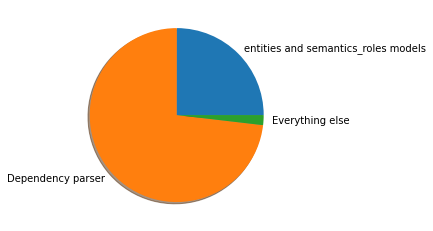

In [15]:
# The measurements used as inputs for this plot are cached on disk and can
# be regenerated if needed by running the code in the last cell of this
# notebook.
timings_df = pd.read_csv("ibm_press_release_timings.csv")  # See below for code to regenerate this CSV file
sums = timings_df[["step_1_sec", "step_2_sec", "step_3_sec", "step_3a_sec", "step_4_sec"]].sum()

# Version of timings that break things down into 5 parts
timings = {
    "Extract entities and semantic roles": sums["step_1_sec"],
    "Identify persons quoted by name": sums["step_2_sec"],
    "Perform dependency parsing": sums["step_3_sec"],
    "Extract titles of persons": sums["step_4_sec"],
    "Combine results across documents": 0.062  # Manually pasted from output later on
}

# Simplified version
timings_short = {
    "entities and semantics_roles models": sums["step_1_sec"],
    "Dependency parser": sums["step_3_sec"],
    "Everything else": sums["step_2_sec"] + sums["step_4_sec"] + 0.062
}

data = timings_short
plt.pie(data.values(), labels=data.keys(), shadow=True)
plt.show()

We can break the running time into three parts:
* calling the Watson Natural Language Understanding web service to run its `entities` and `semantic_roles` models
* calling the SpaCy language model to run its dependency parser.
* everything else, including including reading in the documents, cross-referencing the results of the three models, and merging results across documents

As you can see in the chart, the dependency parser is by far the most expensive part of this application, accounting for nearly 3/4 of the total running time. Dependency parsing has always been an expensive operation, and the latest generation of dependency parsers is even more CPU-intensive.

The code inside `find_titles_of_persons()` that invokes the dependency parser looks like this:

In [16]:
def perform_dependency_parsing(doc_text: str, spacy_language_model):
    """
    First phase of processing from `find_titles_of_persons()`

    Parses a document using SpaCy's depdendency parser, then converts the
    outputs of the parser into a Pandas DataFrame using Text Extensions for Pandas.
    """
    return (
        tp.io.spacy.make_tokens_and_features(doc_text, spacy_language_model)
        [["id", "span", "tag", "dep", "head"]])


To accelerate this function with the semijoin trick, we will need a way to divide the document into independent units of analysis --- in this case, paragraphs.

The source documents are HTML documents, and Watson Natural Language Understanding replaces all HTML paragraph tags with newlines. So we can identify paragraph boundaries by looking for newlines, which allows us to define a function that finds the spans of all paragraphs in the document.

In [17]:
paragraph_break_re = regex.compile(r"\n+")

def find_paragraph_spans(doc_text: str) -> tp.SpanArray:
    """
    Split document text along paragraph boundaries.
    :returns: a SpanArray containing one span per paragraph.
    """
    # Find paragraph boundaries
    break_locs = [(a.start(), a.end()) 
                  for a in regex.finditer(paragraph_break_re, doc_text)]
    boundaries = break_locs + [(len(doc_text), len(doc_text))]

    # Split the document on paragraph boundaries
    begins = []
    ends = []
    begin = 0
    for b in boundaries:
        end = b[0]
        if end > begin:  # Ignore zero-length paragraphs
            begins.append(begin)
            ends.append(end)
        begin = b[1]
    return tp.SpanArray(doc_text, begins, ends)


Now that we have a method of finding paragraph locations, we can create a drop-in replacement for the `perform_dependency_parsing()` function that uses the semijoin trick to reduce the overhead of the SpaCy depdendency parser.

This new `perform_targeted_dependency_parsing()` function runs the dependency parser only over the paragraphs that contain a match of the `find_persons_quoted_by_name()` function.

In [18]:
def perform_targeted_dependency_parsing(
        spans_to_cover: Union[tp.SpanArray, pd.Series],
        language_model: spacy.language.Language) -> pd.DataFrame:  
    """
    Optimized version of :func:`perform_dependency_parsing()` that uses the
    semijoin trick to reduce the overhead of dependency parsing by only 
    parsing the paragraphs where a person is mentioned by name.

    Identifies regions of the document to parse, then parses a those regions
    using SpaCy's depdendency parser, then converts the outputs of the parser 
    into a Pandas DataFrame of spans over the original document using Text 
    Extensions for Pandas.

    :param spans_to_cover: Locations of the results of the 
     :func:`find_persons_quoted_by_name()` function.
    :param language_model: SpaCy language model containing the parser
     configuration
    """
    spans_to_cover = tp.SpanArray.make_array(spans_to_cover)

    # Special case: No spans. Return empty DataFrame with correct schema.
    if len(spans_to_cover) == 0:
        return pd.DataFrame({
            "id": pd.Series([], dtype=int),
            "span": pd.Series([], dtype=tp.SpanDtype()),
            "tag": pd.Series([], dtype=str),
            "dep": pd.Series([], dtype=str),
            "head": pd.Series([], dtype=int),
        })
        return tp.io.spacy.make_tokens_and_features(
            "", language_model
            )[["id", "span", "tag", "dep", "head"]]

    # Break the document into paragraphs and find the paragraphs that contain
    # a match of the 
    doc_text = spans_to_cover.document_text
    all_paragraphs = find_paragraph_spans(doc_text)
   
    covered_paragraphs = (
        tp.spanner.contain_join(pd.Series(all_paragraphs),
                                pd.Series(spans_to_cover),
                                "paragraph", "span")["paragraph"].unique())

    offset = 0
    to_stack = []
    for paragraph_span in covered_paragraphs:
        # Tokenize and parse the paragraph
        paragraph_tokens_raw = tp.io.spacy.make_tokens_and_features(
            paragraph_span.covered_text, language_model
            )[["id", "span", "tag", "dep", "head"]]

        # Convert token spans to original document text
        paragraph_tokens = tp.spanner.join.unpack_semijoin(paragraph_span,
                                                           paragraph_tokens_raw)

        # Adjust token IDs to allow stacking without duplicates
        paragraph_tokens["id"] += offset
        paragraph_tokens["head"] += offset
        paragraph_tokens.index += offset

        to_stack.append(paragraph_tokens)
        offset += len(paragraph_tokens.index)
    return pd.concat(to_stack)

This function produces the same parse trees as the original `perform_dependency_parsing()` function, but it only parses the sentences in the paragraphs that contain a match of the earlier stages of NLP processing.

Let's show the effects of this change in context of an example document.

In [19]:
example_doc_url = "https://newsroom.ibm.com/2021-01-04-IBM-Study-Majority-of-Surveyed-Companies-are-Not-Prepared-for-IT-Needs-of-the-Future-Say-U-S-and-U-K-Tech-Leaders"
example_doc_html = articles.loc[articles["url"] == example_doc_url, "html"].values[0]
display(HTML(textwrap.shorten(example_doc_html, 5000)))

All the NLP code that we use here can be found in this notebook's companion Python file, [market_intelligence.py](./market_intelligence.py).

In [20]:
# Use the versions of these functions in market_intelligence.py
import market_intelligence as mi

Here we refactor the original two functions `find_persons_quoted_by_name()` and `find_titles_of_persons()` slightly to break out the portions of the pipeline that run expensive models so that we can measure how long those parts take.

In [21]:
# Refactored version of the NLP pipeline that breaks out the high-cost
# model evaluations.
def steps_1_through_4(doc_html: str) -> pd.DataFrame:
    
    # Steps 1 and 2, as implemented in find_persons_quoted_by_name()
    step_1_results = mi.extract_named_entities_and_semantic_roles(doc_html, nlu_api)
    step_2_results = mi.identify_persons_quoted_by_name(step_1_results)   
    
    # Steps 3 and 4, as implemented in find_titles_of_persons()
    before_sec = time.time()
    step_3_results = mi.perform_dependency_parsing(step_1_results["analyzed_text"],
                                                   spacy_language_model)
    print(f"\nDependency parsing took {time.time() - before_sec:1.1f} sec.")
    step_4_results = mi.extract_titles_of_persons(step_2_results, step_3_results)
    return step_4_results

In [22]:
steps_1_through_4(example_doc_html)


Dependency parsing took 3.9 sec.


,person,title
0,"[1775, 1794): 'Archana Vemulapalli'","[1796, 1860): 'General Manager, IBM Infrastruc..."


Now we take the same pipeline code and replace the call to `perform_dependency_parsing()` with a call to `perform_targeted_dependency_parsing()`, our version of that function that uses the semijoin trick.

In [23]:
# The same steps 1 through 4, but using the semijoin trick to accelerate dependency
# parsing.
def steps_1_through_4_with_semijoin(doc_html: str) -> pd.DataFrame:
    
    # Steps 1 and 2, as implemented in find_persons_quoted_by_name()
    step_1_results = mi.extract_named_entities_and_semantic_roles(doc_html, nlu_api)
    step_2_results = mi.identify_persons_quoted_by_name(step_1_results)   
    
    # Steps 3 and 4, as implemented in find_titles_of_persons()
    before_sec = time.time()
    step_3_results = mi.perform_targeted_dependency_parsing(
        step_2_results["person"], spacy_language_model)
    print(f"\nDependency parsing took {time.time() - before_sec:1.1f} sec.")
    step_4_results = mi.extract_titles_of_persons(step_2_results, step_3_results)
    return step_4_results

In [24]:
steps_1_through_4_with_semijoin(example_doc_html)


Dependency parsing took 0.4 sec.


,person,title
0,"[1775, 1794): 'Archana Vemulapalli'","[1796, 1860): 'General Manager, IBM Infrastruc..."


As the output shows, the semijoin trick reduces the cost of dependency parsing on this document by more than 90 percent. If we repeat this performance measurement across our entire collection of 191 documents.

In [25]:
# Don't include this cell in the blog, but do include its output chart.
# Aggregate the results of profiling across the entire corpus.
# The measurements used as inputs for this calculation are cached and can
# be regenerated by running the last cell.


import numpy as np

sums = timings_df.sum()

timings = {
    "Extract entities and semantic roles": [sums["step_1_sec"], sums["step_1_sec"]],
    "Identify persons quoted by name": [sums["step_2_sec"],sums["step_2_sec"]],
    "Perform dependency parsing": [sums["step_3_sec"], sums["step_3a_sec"]],
    "Extract titles of persons": [sums["step_4_sec"],sums["step_4_sec"]],
    "Combine results across documents": [0.062, 0.062]
}

for name, tuple_ in timings.items():
    before, after = tuple_
    print(f"{name:>35s}: {before:1.1f} sec before and {after:1.1f} sec after")

print("\n")
print(f"Total time before: {sum([v[0] for v in timings.values()])}")
print(f"Total time after: {sum([v[1] for v in timings.values()])}")

Extract entities and semantic roles: 218.7 sec before and 218.7 sec after
    Identify persons quoted by name: 5.1 sec before and 5.1 sec after
         Perform dependency parsing: 640.5 sec before and 73.3 sec after
          Extract titles of persons: 11.0 sec before and 11.0 sec after
   Combine results across documents: 0.1 sec before and 0.1 sec after


Total time before: 875.3122136230469
Total time after: 308.0950550670624


Over the entire collection, the semijoin trick reduces amount of time spent on dependency parsing from 641 seconds to 73 seconds. That step now runs **nine times faster**! 

Speeding up this one phase of the pipeline results in a significant improvement in how fast the entire pipeline runs. The chart below shows the detailed breakdown of how long each processing step took before and after we applied the semijoin trick to this pipeline.

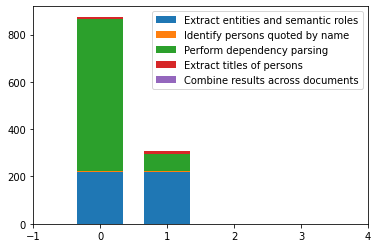

In [26]:
# Turn the above 
# Plot the results of profiling across the entire corpus.
# The measurements used as inputs for this plot are cached on disk and can
# be regenerated if needed by running the code in the last cell of this
# notebook.

# TODO: Pretty up this plot and get the legend in the same order as the bars
cur_sum = np.zeros(2)
for k, v in timings.items():
    plt.bar([0, 1], v, bottom=cur_sum, label=k, width=0.7)
    cur_sum += np.array(v)
    
plt.xlim([-1, 4])
plt.legend()
plt.show()

Before we apply the semijoin trick, dependency parsing represents the largest portion of the running time. By removing almost 90 percent of this parsing overhead, the semijoin trick reduces the overall running time for the entire pipeline from 875 seconds to 308 seconds. The end-to-end pipeline is now almost 3 times faster.

In [27]:
# TODO: Don't include this cell in the main flow, but do include the graph that the next cell 
# produces.

# If the cached timings file isn't present, run a benchmark to regenerate it.
if not os.path.exists("ibm_press_release_timings.csv"):
    # Cached timing data not present. Regenerate it.
    benchmark_api_key = api_key
    benchmark_service_url = service_url
    #benchmark_api_key = os.environ.get("STANDARD_API_KEY")
    #benchmark_service_url = os.environ.get("STANDARD_SERVICE_URL")  

    nlu_api = ibm_watson.NaturalLanguageUnderstandingV1(version="2021-01-01", 
                authenticator=ibm_cloud_sdk_core.authenticators.IAMAuthenticator(benchmark_api_key))
    nlu_api.set_service_url(benchmark_service_url)
    spacy_language_model = spacy.load("en_core_web_trf")

    dataframes_to_stack = []
    timings = []

    article_subset = articles

    for url, html in zip(article_subset["url"], article_subset["html"]):

        start_time = time.time()

        step_1_results = mi.extract_named_entities_and_semantic_roles(html, nlu_api)
        step_1_time = time.time()

        step_2_results = mi.identify_persons_quoted_by_name(step_1_results)
        step_2_time = time.time()

        step_3_results = mi.perform_dependency_parsing(step_1_results["analyzed_text"],
                                                       spacy_language_model)
        step_3_time = time.time()
        
        step_3a_results = mi.perform_targeted_dependency_parsing(step_2_results["person"],
                                                       spacy_language_model)
        step_3a_time = time.time()

        step_4_results = mi.extract_titles_of_persons(step_2_results, step_3_results)
        step_4_time = time.time()

        dataframes_to_stack.append(step_4_results)
        timings.append({
            "url": url,
            "step_1_sec": step_1_time - start_time,
            "step_2_sec": step_2_time - step_1_time,
            "step_3_sec": step_3_time - step_2_time,
            "step_3a_sec": step_3a_time - step_3_time,
            "step_4_sec": step_4_time - step_3a_time
        })

    step_5_start_time = time.time()
    step_5_results = pd.concat(dataframes_to_stack)
    step_5_time = time.time() - step_5_start_time
    print(f"Step 5 took {step_5_time:1.3f} sec.")
    
    pd.DataFrame.from_records(timings).to_csv("ibm_press_release_timings.csv")
